The notebook will be used to see how my model work for different sets of data separated by loss. The current dataset has a large number of particles loss at the end so it's prediction of the loss would be more accuracte for small loss values compared to larger loss values just due to the number of data. I will bin the data and see, given 1000 samples of each, how well the loss values was calculated.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
#matplotlib graphs will be included in your notebook, next to the code:
%matplotlib inline

# Neural networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision

import h5py
import os

from CNNModels import *

In [2]:
class H5Dataset(torch.utils.data.Dataset):
    # Given a list of h5_path files, extract the voltage, distribution, and loss values
    def __init__(self, h5_paths, transform=False, size = 94):
        self.h5_paths = h5_paths
        self.transform=transform
        self.size = size
        # Code to get data from hdf5 files and put into memory
        i=0
        self.voltages, distro, output= self.extract_data(h5_paths[i])
        self.distro_0 = distro[0]
        self.distro_1 = distro[1]
        self.distro_2 = distro[2]
        self.distro_3 = distro[3]
        self.distro_4 = distro[4]
        self.output_0 = output[0]
        self.output_1 = output[1]
        self.output_2 = output[2]
        self.output_3 = output[3]
        i+=1
        while(i<len(h5_paths)):
            if h5_paths[1].endswith('.hdf5'):
                a, b, c = self.extract_data(h5_paths[i])
                self.voltages = np.concatenate((self.voltages,a))
                self.distro_0 = np.concatenate((self.distro_0,b[0]))
                self.distro_1 = np.concatenate((self.distro_1,b[1]))
                self.distro_2 = np.concatenate((self.distro_2,b[2]))
                self.distro_3 = np.concatenate((self.distro_3,b[3]))
                self.distro_4 = np.concatenate((self.distro_4,b[4]))
                self.output_0 = np.concatenate((self.output_0,c[0]))
                self.output_1 = np.concatenate((self.output_1,c[1]))
                self.output_2 = np.concatenate((self.output_2,c[2]))
                self.output_3 = np.concatenate((self.output_3,c[3]))
            i+=1
        # Make sure all particles that starts are inside the aperature
        distro_sum = self.distro_0.sum(axis=(1,2,3))
        mask = distro_sum>60000
        self.voltages = self.voltages[mask]
        self.distro_0 = self.distro_0[mask]
        self.distro_1 = self.distro_1[mask]
        self.distro_2 = self.distro_2[mask]
        self.distro_3 = self.distro_3[mask]
        self.distro_4 = self.distro_4[mask]
        self.output_0 = self.output_0[mask]
        self.output_1 = self.output_1[mask]
        self.output_2 = self.output_2[mask]
        self.output_3 = self.output_3[mask]
        # normalizing the data from [-1,1]
        self.voltages = self.voltages/8
        self.len = len(self.output_0)
        
        self.resize = torchvision.transforms.Resize((self.size,self.size))

    def __getitem__(self, index):
        if (self.transform):
            return ((self.voltages[index],  # voltages on quad
                     self.Resize(self.distro_0[index]),  # Distribution images
                     self.Resize(self.distro_1[index]),
                     self.Resize(self.distro_2[index]),
                     self.Resize(self.distro_3[index]),
                     self.Resize(self.distro_4[index])),
                    (self.output_0[index],  # outputs
                     self.output_1[index],
                     self.output_2[index],
                     self.output_3[index]))
        else:
            return ((self.voltages[index],  # voltages on quad
                     self.distro_0[index],  # Distribution images
                     self.distro_1[index],
                     self.distro_2[index],
                     self.distro_3[index],
                     self.distro_4[index]),
                    (self.output_0[index],  # outputs
                     self.output_1[index],
                     self.output_2[index],
                     self.output_3[index]))

    def __len__(self):
        return self.len
    
    def Resize(self, data):
        s = np.array(data).shape
        tempdata = torch.zeros((self.size, self.size, s[-1]))
        for i in range(s[-1]):
            tempdata[:,:,i] = self.resize(torch.from_numpy(data[:,:,i]).squeeze().unsqueeze(dim=0))
        return np.array(tempdata)
    
    def get_memory(self):
        """
        Return memory in GBs
        """
        memory = self.voltages.nbytes
        memory += self.distro_0.nbytes
        memory += self.distro_1.nbytes
        memory += self.distro_2.nbytes
        memory += self.distro_3.nbytes
        memory += self.distro_4.nbytes
        memory += self.output_0.nbytes
        memory += self.output_1.nbytes
        memory += self.output_2.nbytes
        memory += self.output_3.nbytes # float32 has 4 byte
        memory = memory/1028**3
        return memory
    
    def extract_data(self, file):
        with h5py.File(file, 'r') as f:
            v = pd.DataFrame(f['Input/v1'])
            nonzero = (v.shape[0]-(v==0).sum())[0]  # Get number of nonzero values from file
            print(nonzero)
            v1 = f['Input/v1'][:nonzero]
            v2 = f['Input/v2'][:nonzero]
            v3 = f['Input/v3'][:nonzero]
            v4 = f['Input/v4'][:nonzero]
            v5 = f['Input/v5'][:nonzero]
            v6 = f['Input/v6'][:nonzero]
            v = pd.DataFrame([v1,v2,v3,v4,v5,v6]).T  # This creates a vector of voltage data

            exit_left = [None]*4
            exit_left[0] = f['08_drift/#of_part_left'][:nonzero]  #Get number of particles after first quad pair
            exit_left[1] = f['11_drift/#of_part_left'][:nonzero]  #Get number of particles after second quad pair
            exit_left[2] = f['14_drift/#of_part_left'][:nonzero]  #Get number of particles after third quad pair
            exit_left[3] = f['18_drift/#of_part_left'][:nonzero]  #Get number of particles left at the last element
            ploss_0 = pd.DataFrame(exit_left[0]) 
            ploss_1 = pd.DataFrame(exit_left[1]) 
            ploss_2 = pd.DataFrame(exit_left[2]) 
            ploss_3 = pd.DataFrame(exit_left[3]) 

            distro = [None]*5
            distro[0] = f['Input/33x33_0'][:nonzero,:,:,:]
            distro[1] = f['Input/33x33_1'][:nonzero,:,:,:]
            distro[2] = f['Input/33x33_2'][:nonzero,:,:,:]
            distro[3] = f['Input/33x33_3'][:nonzero,:,:,:]
            distro[4] = f['Input/33x33_4'][:nonzero,:,:,:]
            print(distro[0].shape)

        voltage = v.values
        distro = np.array(distro)
        loss = np.array(exit_left)
        return (voltage, distro, loss)

In [3]:
# Make a function to get data from a list of files
hdf5_dir = "/mnt/gs18/scratch/users/tranant2/Test"
files = os.listdir(hdf5_dir)
hdf5_files1 = [(hdf5_dir + '/'+i) for i in files ]
hdf5_files1

['/mnt/gs18/scratch/users/tranant2/Test/data_0.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_9.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_28.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_22.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_2.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_29.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_27.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_4.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_3.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_31.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_13.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_24.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_30.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_21.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_7.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_26.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_6.hdf5',
 '/mnt/gs18/scratch/users/tranant2/Test/data_17.hdf5',
 '/mnt/gs18/scrat

In [4]:
dataset = H5Dataset(hdf5_files1, transform=False)

256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)
256
(256, 33, 33, 6)


In [5]:
len(dataset)

8189

In [6]:
test_loader = DataLoader(dataset=dataset, batch_size = len(dataset), shuffle=True)

In [8]:
print(f"Is GPU avaliable: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Got the: {torch.cuda.get_device_name(0)}")
    print(f"Total memory: {torch.cuda.get_device_properties(0).total_memory/(1028**3)} GB")

Is GPU avaliable: True
Got the: Tesla K80
Total memory: 11.781983108519892 GB


In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Computation will be happening on the {device}")

Computation will be happening on the cuda:0


In [10]:
model = VAE().to(device)

In [11]:
model.load_state_dict(torch.load( f"/mnt/ufs18/home-032/tranant2/Desktop/MachineLearning/TRACK/CNN9/model__{1}.pth"), strict=False)

<All keys matched successfully>

In [12]:
examples = enumerate(test_loader)
batch_idx, (test_data, test_targets) = next(examples)

In [14]:
voltages = test_data[0].to(device)
distro_0 = test_data[1].to(device)
distro_1 = test_data[2].to(device)
distro_2 = test_data[3].to(device)
distro_3 = test_data[4].to(device)
distro_4 = test_data[5].to(device)
output_0 = test_targets[0].to(device)
output_1 = test_targets[1].to(device)
output_2 = test_targets[2].to(device)
output_3 = test_targets[3].to(device)

(array([3974., 1695.,  890.,  547.,  371.,  253.,  170.,  135.,   99.,
          55.]),
 array([8.0000e+00, 9.9740e+02, 1.9868e+03, 2.9762e+03, 3.9656e+03,
        4.9550e+03, 5.9444e+03, 6.9338e+03, 7.9232e+03, 8.9126e+03,
        9.9020e+03], dtype=float32),
 <BarContainer object of 10 artists>)

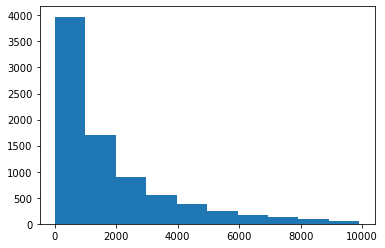

In [22]:
plt.hist(np.array(output_3.cpu()), bins=10)

In [39]:
mask = [None]*10
for i in range(10):
    mask[i] = (output_3>1000*(i))*(output_3<1000*(i+1))

(array([4., 7., 7., 7., 6., 3., 6., 5., 3., 1.]),
 array([9018. , 9106.4, 9194.8, 9283.2, 9371.6, 9460. , 9548.4, 9636.8,
        9725.2, 9813.6, 9902. ], dtype=float32),
 <BarContainer object of 10 artists>)

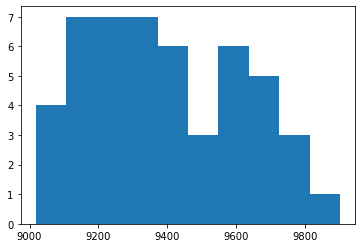

In [41]:
plt.hist(np.array(output_3[mask[9]].cpu()), bins=10)

For the 0 loss location, mean:99.77768090820312. std:64.67022885918475
For the 1 loss location, mean:60.408100646972656. std:55.24277132148285
For the 2 loss location, mean:43.181763053894045. std:42.978439667520135
For the 3 loss location, mean:38.367110025405886. std:40.46012261110402


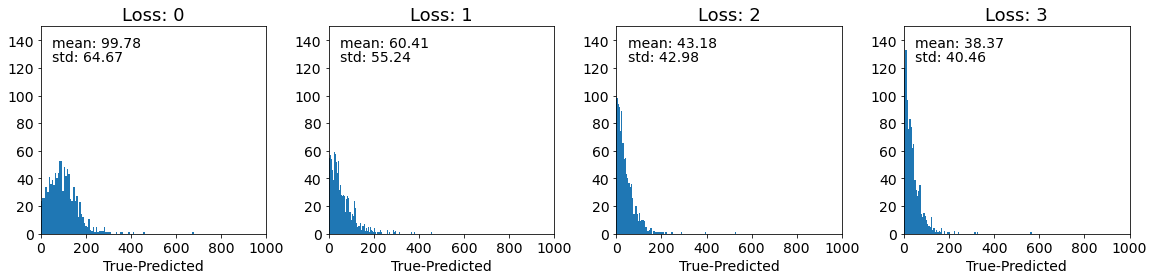

For the 0 loss location, mean:112.40234704589844. std:55.333778970922424
For the 1 loss location, mean:77.1302373046875. std:68.91981005607315
For the 2 loss location, mean:81.22186987304687. std:73.56506327744239
For the 3 loss location, mean:80.78513641357422. std:66.20985051513726


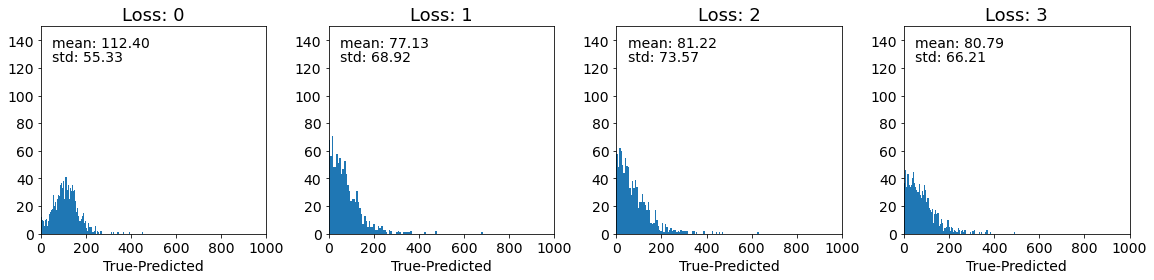

For the 0 loss location, mean:115.57821555497816. std:50.6815872812016
For the 1 loss location, mean:74.33811150758349. std:69.84521012226956
For the 2 loss location, mean:106.76799209061443. std:91.763405496968
For the 3 loss location, mean:116.73808871745526. std:94.01285113667572


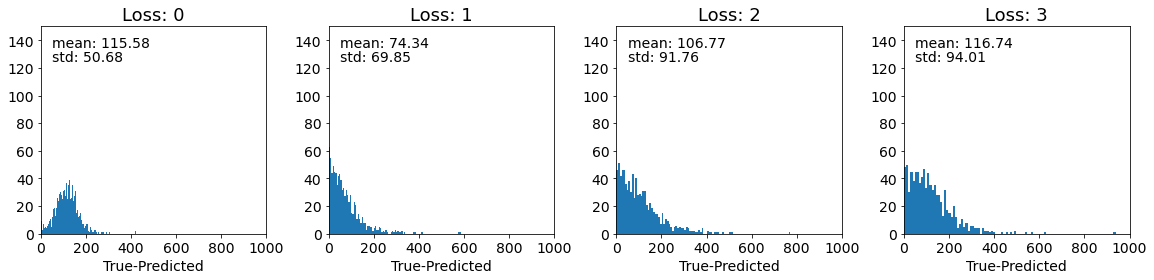

For the 0 loss location, mean:122.6240148790648. std:52.12062980009053
For the 1 loss location, mean:77.21648246511762. std:65.9298899697303
For the 2 loss location, mean:144.03508147630305. std:119.89698759662572
For the 3 loss location, mean:164.33759423287592. std:137.01991625784126


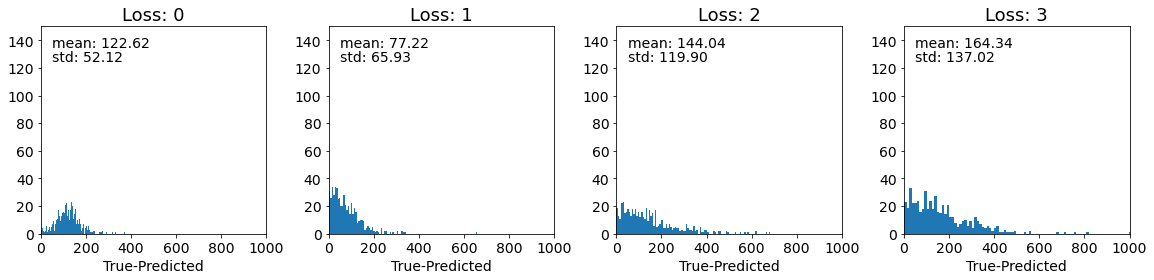

For the 0 loss location, mean:119.6905861207691. std:47.407235226219946
For the 1 loss location, mean:81.08535038434148. std:66.38129927092686
For the 2 loss location, mean:151.02317045073727. std:135.6227141333387
For the 3 loss location, mean:177.04136056363103. std:159.12163568907616


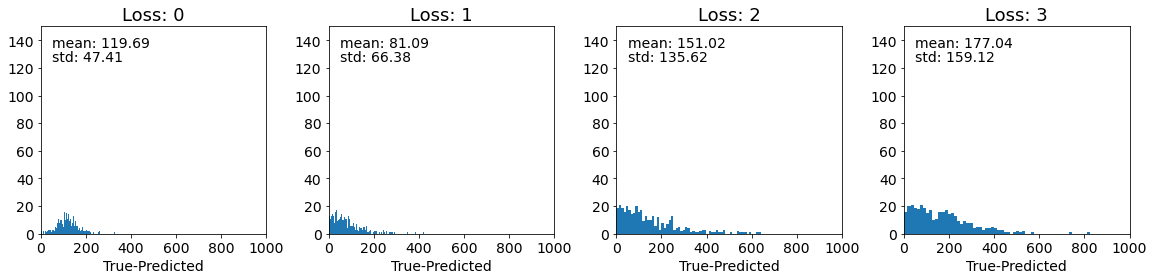

For the 0 loss location, mean:125.6627094314759. std:50.17398354348864
For the 1 loss location, mean:81.3330725244729. std:67.43582478900711
For the 2 loss location, mean:161.88097311119478. std:139.36518339963325
For the 3 loss location, mean:194.03276975087851. std:148.20431133092055


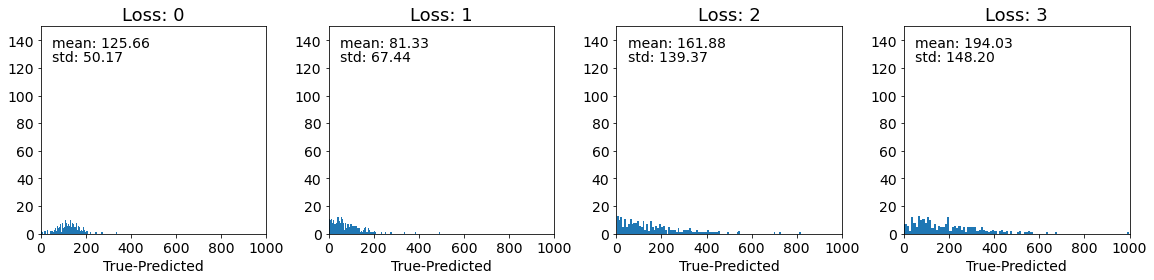

For the 0 loss location, mean:125.47845635386561. std:40.352093149027056
For the 1 loss location, mean:72.19329445899567. std:66.9061430733089
For the 2 loss location, mean:171.57990595646677. std:146.32474617914994
For the 3 loss location, mean:211.60169515444363. std:163.41636874604208


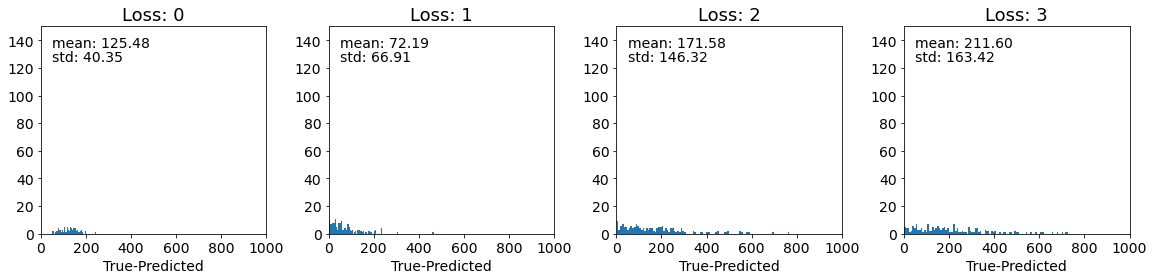

For the 0 loss location, mean:123.86805308948864. std:45.60804371164061
For the 1 loss location, mean:80.46592758641098. std:69.23882104864845
For the 2 loss location, mean:177.125107273911. std:153.14072001907013
For the 3 loss location, mean:210.03662109375. std:168.08408285038198


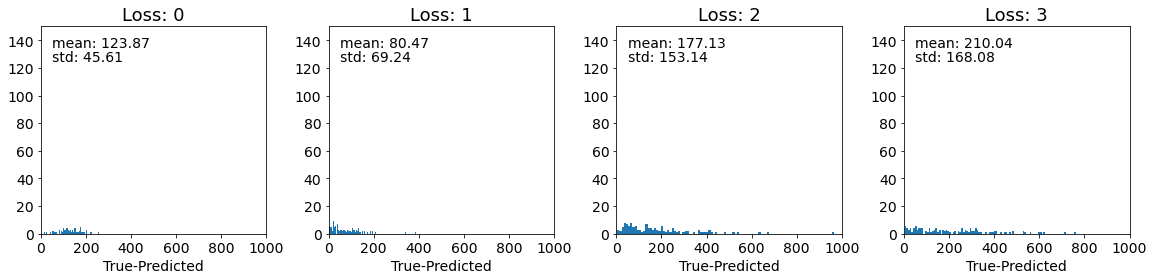

For the 0 loss location, mean:134.09893928690158. std:42.21188778021766
For the 1 loss location, mean:66.34172415226064. std:51.2556545982477
For the 2 loss location, mean:153.46438144115692. std:101.55144676245743
For the 3 loss location, mean:221.5601468999335. std:150.84459844936316


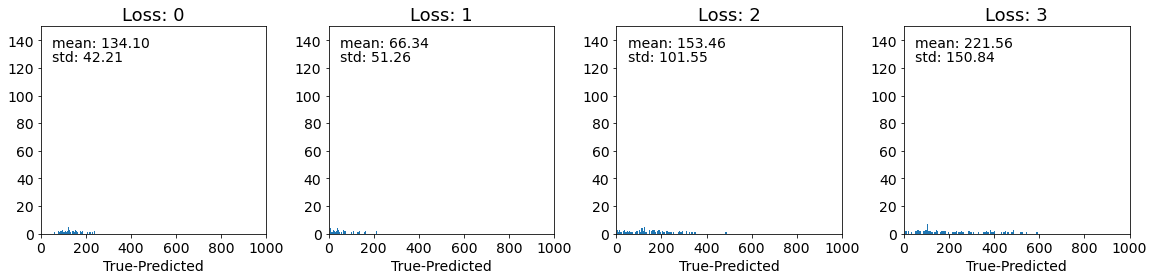

For the 0 loss location, mean:128.4772799744898. std:44.49977288750236
For the 1 loss location, mean:61.97478874362245. std:47.43219322004609
For the 2 loss location, mean:196.02303890306123. std:134.52423384122912
For the 3 loss location, mean:185.02046795280611. std:157.66375672515028


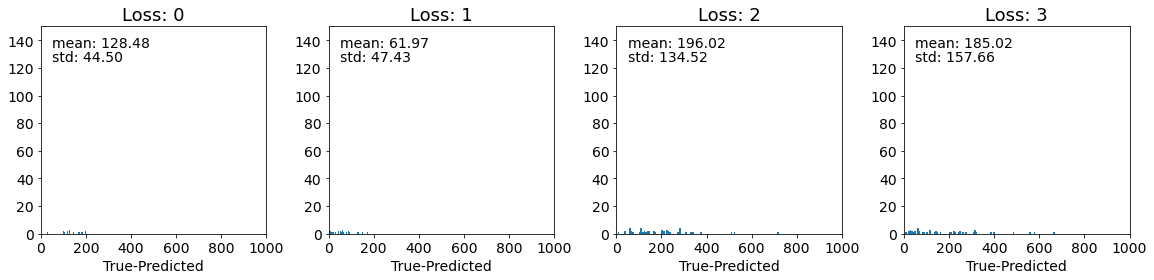

In [47]:
for m in mask:
    voltages_m = voltages[m]
    distro_0_m = distro_0[m]
    distro_1_m = distro_1[m]
    distro_2_m = distro_2[m]
    distro_3_m = distro_3[m]
    distro_4_m = distro_4[m]
    output_0_m = output_0[m]
    output_1_m = output_1[m]
    output_2_m = output_2[m]
    output_3_m = output_3[m]
    if len(m)>=1000:
        voltages_m = voltages_m[:1000]
        distro_0_m = distro_0_m[:1000]
        distro_1_m = distro_1_m[:1000]
        distro_2_m = distro_2_m[:1000]
        distro_3_m = distro_3_m[:1000]
        distro_4_m = distro_4_m[:1000]
        output_0_m = output_0_m[:1000]
        output_1_m = output_1_m[:1000]
        output_2_m = output_2_m[:1000]
        output_3_m = output_3_m[:1000]
    with torch.no_grad():
        distro, losses = model(voltages=voltages_m,
                           distro0=distro_0_m,
                           distro1=distro_1_m,
                           distro2=distro_2_m,
                           distro3=distro_3_m,
                           distro4=distro_4_m,
                           output0=output_0_m,
                           output1=output_1_m,
                           output2=output_2_m,
                           output3=output_3_m)
    diff = np.zeros((4, losses[0].shape[0]))
    diff[0] = output_0_m.cpu()-losses[0].cpu()  # If positive error, model tends to underestimate
    diff[1] = output_1_m.cpu()-losses[1].cpu()
    diff[2] = output_2_m.cpu()-losses[2].cpu()
    diff[3] = output_3_m.cpu()-losses[3].cpu()
    for i in range(4):
        u = np.mean(np.abs(diff[i]))
        sd = np.std(np.abs(diff[i]))
        print(f"For the {i} loss location, mean:{u}. std:{sd}")
    fig = plt.figure(figsize=(16,4))
    for i in range(4):
        plt.subplot(1,4,i+1)
        plt.tight_layout()
        plt.hist(np.abs(diff[i]), bins=100)
        plt.xlabel('True-Predicted', fontsize=14)
        plt.title(f"Loss: {i}", fontsize=18)
        plt.xlim(0,1000)
        plt.ylim(0,150)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        u = np.mean(np.abs(diff[i]))
        sd = np.std(np.abs(diff[i]))
        plt.text(50, 135, "mean: {:.2f}".format(u), fontsize=14)
        plt.text(50, 125, "std: {:.2f}".format(sd), fontsize=14)
    plt.show()